In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
import pandas as pd
import os
import PIL.Image as img
import matplotlib.pyplot as plt
import regex as re

In [19]:
path=os.getcwd()
print(path)
paths=pd.read_csv('metadata_indoor.csv')
paths.head()

c:\Users\user\projects\DHaRT


,image_id,clear_image_path,hazy_image_paths
0,1400,clear/1400.png,"['hazy/1400_1.png', 'hazy/1400_2.png', 'hazy/1..."
1,1401,clear/1401.png,"['hazy/1401_1.png', 'hazy/1401_2.png', 'hazy/1..."
2,1402,clear/1402.png,"['hazy/1402_1.png', 'hazy/1402_2.png', 'hazy/1..."
3,1403,clear/1403.png,"['hazy/1403_1.png', 'hazy/1403_2.png', 'hazy/1..."
4,1404,clear/1404.png,"['hazy/1404_1.png', 'hazy/1404_2.png', 'hazy/1..."


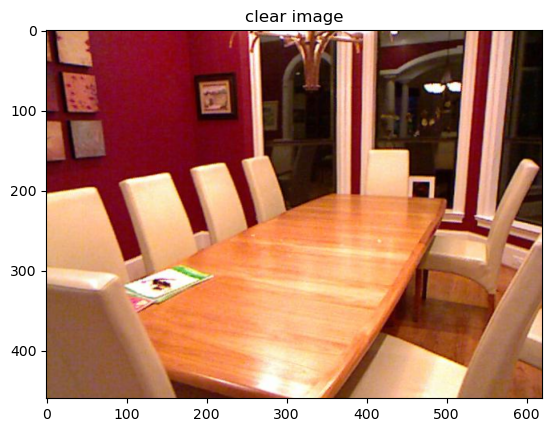

In [51]:
image=img.open(os.path.join(path,'indoor',paths['clear_image_path'].iloc[0]))
plt.title('clear image')
plt.imshow(image)

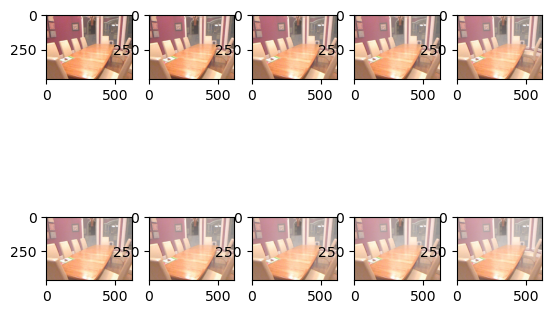

In [52]:
for i in range(0,10):
    image=img.open(os.path.join(path,'indoor','hazy',f'1400_{i+1}.png'))
    plt.subplot(2,5,i+1)
    plt.imshow(image)

In [11]:
def self_attention(x, filters):
    # Get the shape of the input tensor
    input_shape = tf.shape(x)
    height, width = input_shape[1], input_shape[2]
    print(height,width)

    # Reshape query, key, and value tensors
    query = Conv2D(filters // 8, 1)(x)
    query = tf.reshape(query, [-1, height * width, filters // 8])

    key = Conv2D(filters // 8, 1)(x)
    key = tf.reshape(key, [-1, height * width, filters // 8])

    value = Conv2D(filters, 1)(x)
    value = tf.reshape(value, [-1, height * width,  filters // 8])

    # Apply attention mechanism
    attention = tf.keras.layers.Attention(name='Attention_layer')([query, key, value])

    # Reshape attention tensor
    attention = tf.reshape(attention, [-1, height, width, filters])
    return attention

def sidnet_with_attention():
    # Encoder
    inputs = tf.keras.Input(shape=(620, 460, 3),name='InputLayer')
    conv1 = Conv2D(64, 3, activation='relu', padding='same',name='FirstConv')(inputs)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides=2,name='SecondConv')(conv1)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', strides=2,name='ThirdConv')(conv2)

    # Self-attention applied to the encoder output
    attention = self_attention(conv3, 256)

    # Decoder
    deconv1 = Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2,name='FirstDeConv')(attention)
    skip1 = Concatenate(name='FirstSkip')([deconv1, conv2])
    deconv2 = Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2,name='SecondDeConv')(skip1)
    skip2 = Concatenate(name='SecondSkip')([deconv2, conv1])
    output = Conv2D(3, 3, activation='sigmoid', padding='same',name='OutputLayer')(skip2)

    model = tf.keras.Model(inputs=inputs, outputs=output,name='DHaRT')
    return model

# Create an instance of the SIDNet model with attention
model = sidnet_with_attention()

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[155], name='tf.__operators__.getitem_4/strided_slice:0', description="created by layer 'tf.__operators__.getitem_4'") KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[115], name='tf.__operators__.getitem_5/strided_slice:0', description="created by layer 'tf.__operators__.getitem_5'")


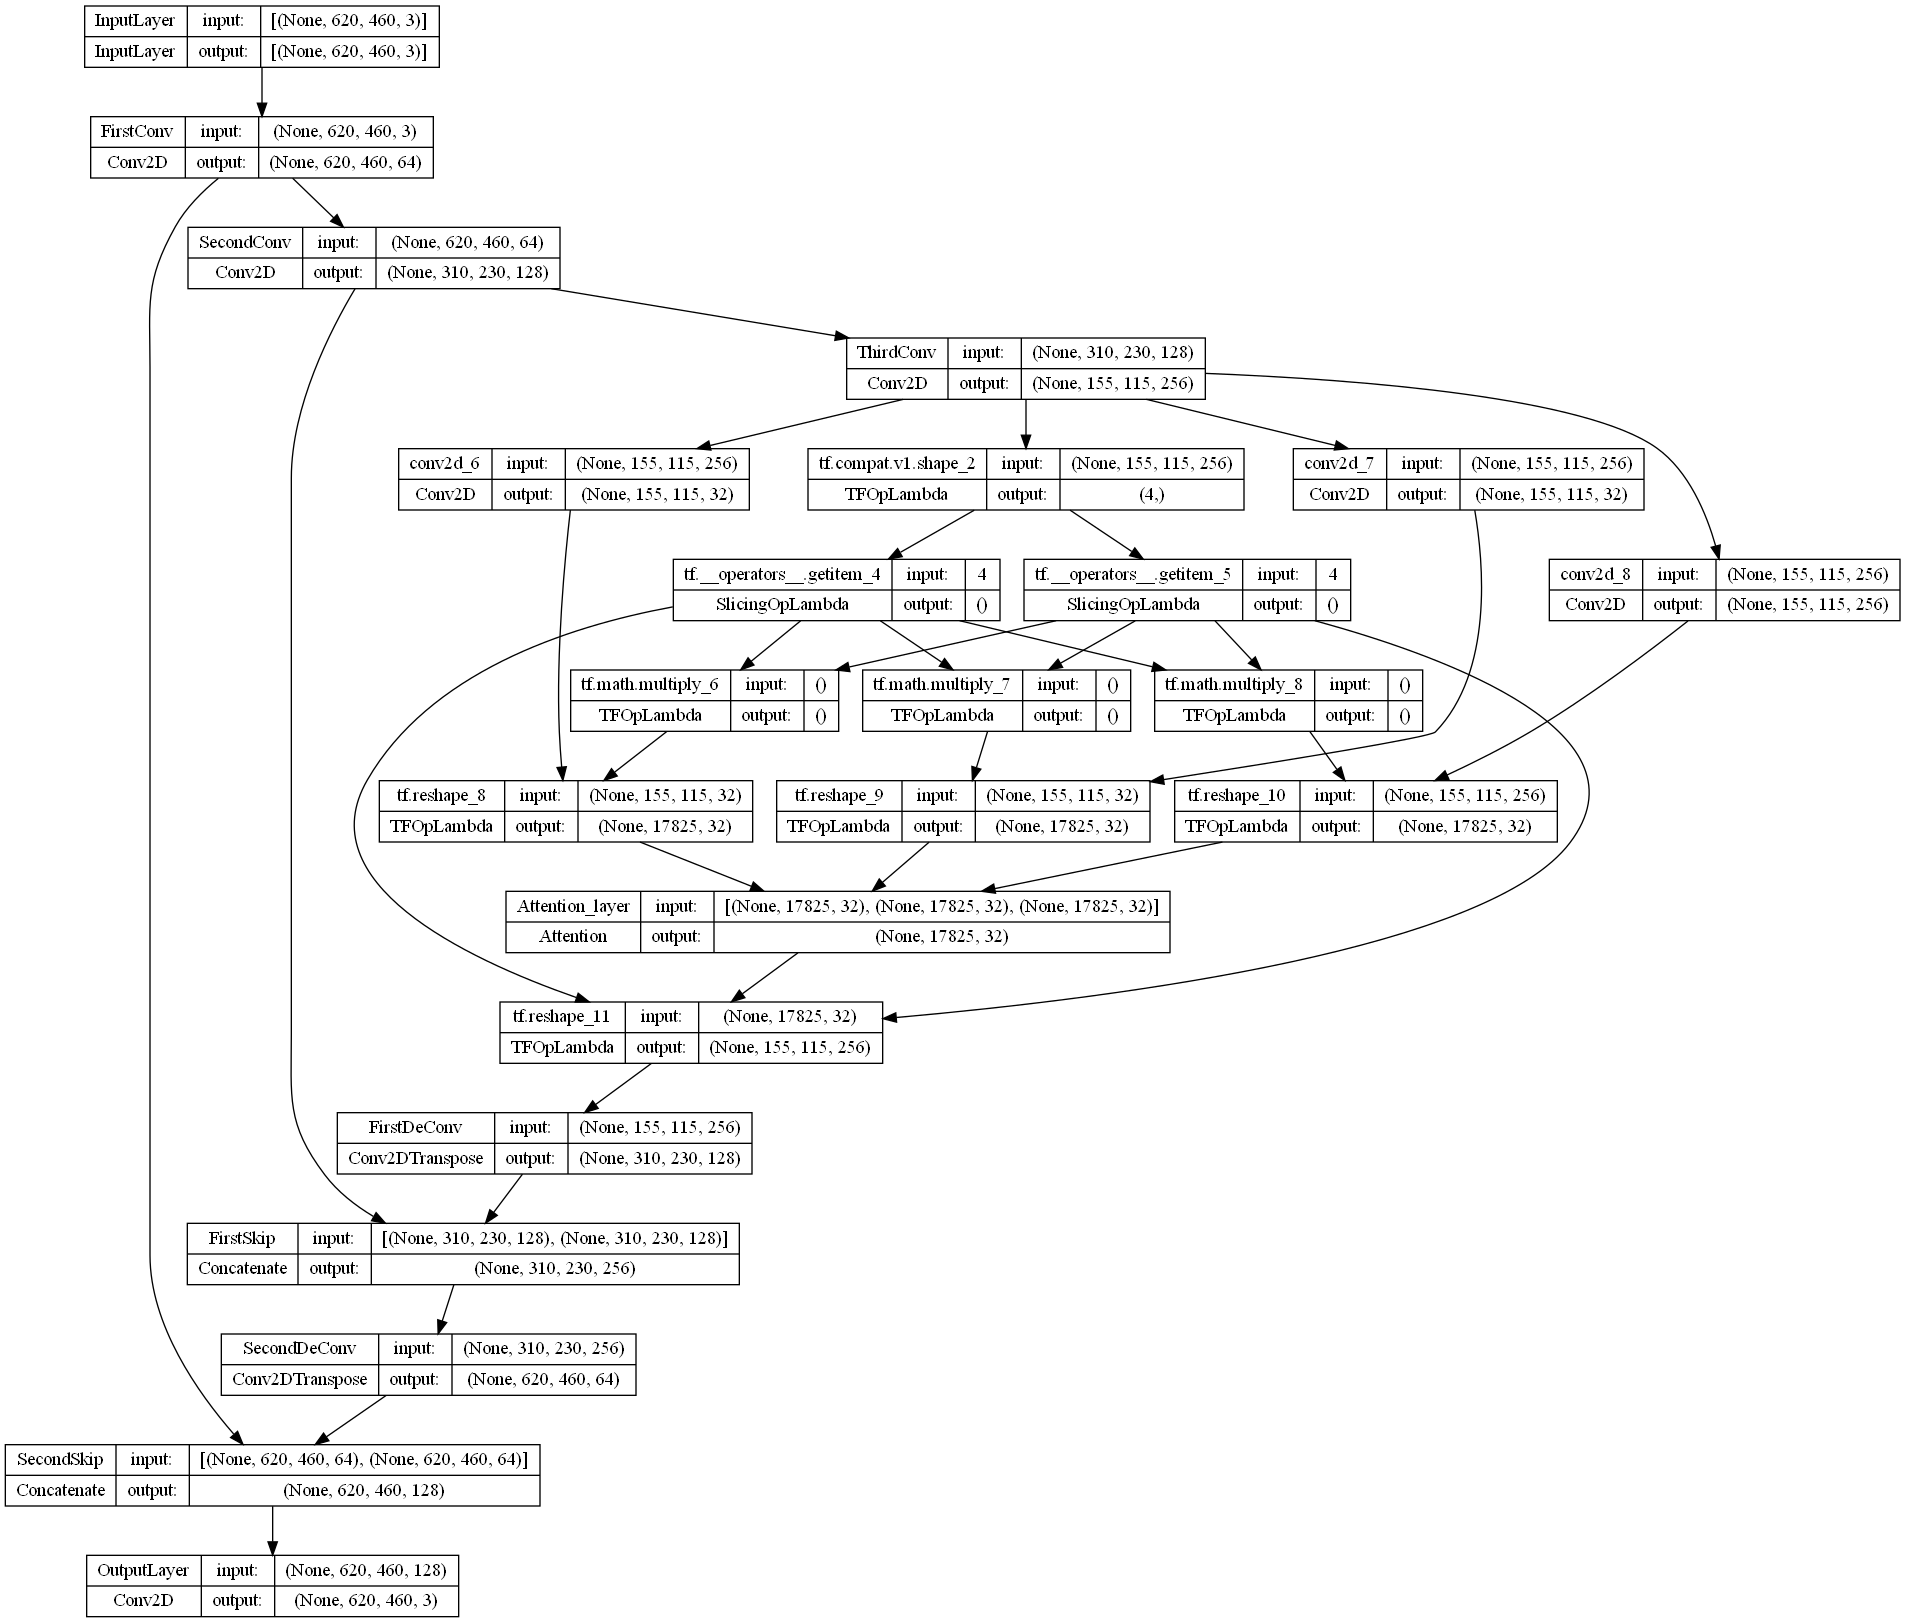

In [12]:
keras.utils.plot_model(model,show_shapes=True)

In [13]:
model.summary()

Model: "DHaRT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 620, 460, 3  0           []                               
                                )]                                                                
                                                                                                  
 FirstConv (Conv2D)             (None, 620, 460, 64  1792        ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 SecondConv (Conv2D)            (None, 310, 230, 12  73856       ['FirstConv[0][0]']              
                                8)                                                            

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])